**Pre-processing data**:
Steps:
1. Read the dataset and the metadata
2. Store the dataset using xarray data structures

In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import xarray as xr
import platform
from pathlib import Path
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

    
def read_data(csv_file_path='../data/train-orig.csv', tiff_folder_path='../data/train/'):
    df_meta = pd.read_csv(csv_file_path)
    im_list = []
    for i,imid in enumerate(df_meta.Image_ID):
        im = Image.open(tiff_folder_path+str(imid)+'.tif')
        if np.array(im).shape[1]>1024:
            im_list.append(np.array(im))
        if np.array(im).shape[1]<=1024:
            im = im.resize((2048,2048))
            im_list.append(np.array(im))

    ds = xr.Dataset({'greyscale':xr.DataArray(np.array(im_list))})
    ds = ds.rename({'dim_0':'image_id', 'dim_1':'x', 'dim_2':'y'})
    ds['sample'] = 'image_id', df_meta.Sample
    ds['lifetime'] = 'image_id', df_meta.Lifetime
    ds['magnification'] = 'image_id', df_meta.Magnification
    ds['uncertainty'] = 'image_id', df_meta.Uncertainty
    ds['image_id'] = 'image_id', df_meta.Image_ID
    return ds



In [4]:
data_frame = read_data()


**Storing the training data and labels**

In [5]:
X = data_frame['greyscale']
Y = data_frame['lifetime']

**Functions to plot the augmented images**

In [37]:
#Functions to display the images used in this experiment
def show_image_batch(images: list):
    """
    Displays a batch of image present in images
    """
    fig = plt.figure(figsize=(50,50))
    for idx in range(10):
        ax = plt.subplot(5, 2, idx+1)
        plt.imshow(images[idx])
        plt.axis("off")

def show_dataset(dataset):
    batch = next(iter(dataset))
    images, labels = batch
    
    plt.figure(figsize=(10, 10))
    for idx in range(9):
        ax = plt.subplot(3, 3, idx + 1)
        plt.imshow(images[idx].numpy().astype("uint8"))
        plt.title("Class: {}".format(class_names[labels[idx].numpy()]))
        plt.axis("off")

**Image augmentation code**

In [39]:
data_augmentation = keras.Sequential([
   # keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, -0.2),width_factor=(-0.3, -0.2)),
    keras.layers.experimental.preprocessing.RandomContrast(factor=(0.1, 2))
    #keras.layers.experimental.preprocessing.RandomCrop(height=512,width=512,seed=42)
])

Plotting and checking the augmented images

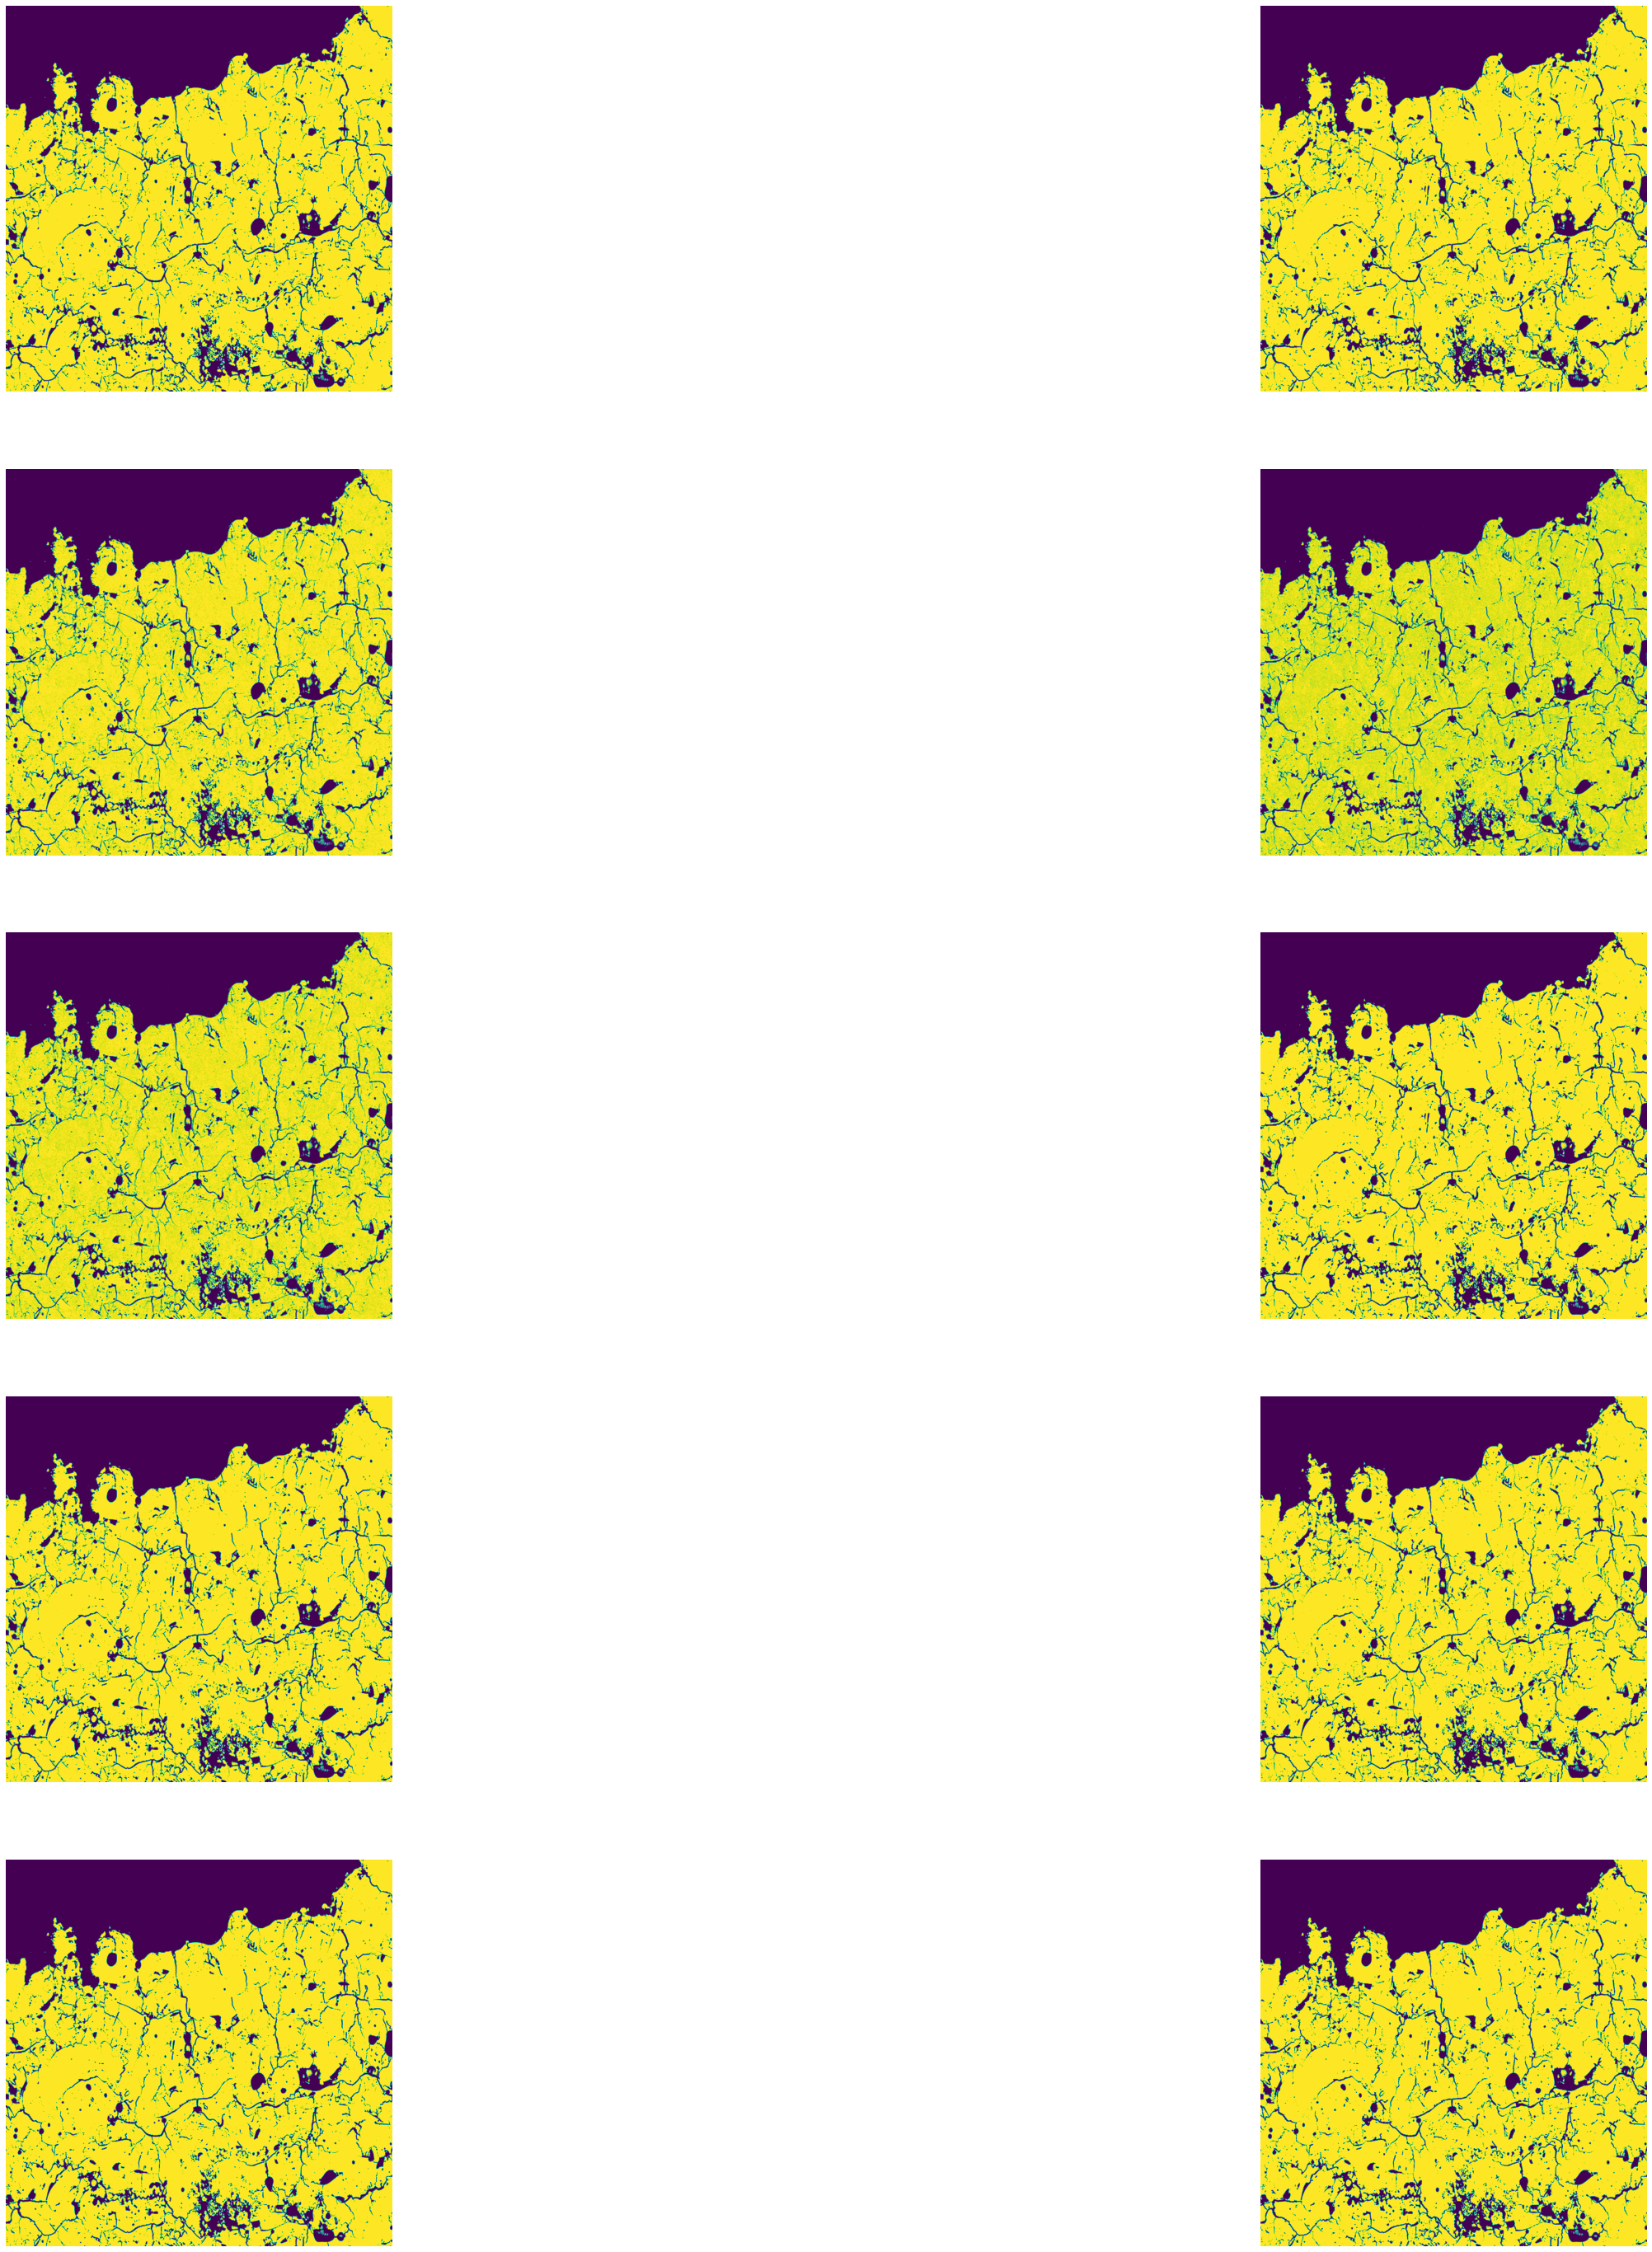

In [40]:
_batch = []
fn = data_augmentation
image = np.expand_dims(X[15,:,:],-1)
#image = (1, image1[:,1], image1[:,0], 1)
for _ in range(18):
    _image = np.array(image)
    _image = np.expand_dims(_image, axis=0)
    _image = fn(_image, training=True)
    _batch.append(np.uint(_image[0]))
show_image_batch(_batch)